「このノートブックの冒頭では、CSVファイルなどのデータを扱うための pandas と numpy、

そしてニューラルネットワークの構築・学習のために PyTorch をインポートしています。

また、データを標準化したり、学習用と検証用に分けたりするための scikit-learn も使っています。」

In [105]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


今いる作業ディレクトリを確認するために os.getcwd() を使っています。

これによって、相対パスでファイルを読み込むときに、正しく指定できているか確認できます

In [106]:
import os
print(os.getcwd())

c:\Users\21td031\Documents\motion2music\notebooks


このコードでは、指定フォルダ内のCSVファイルをすべて読み込んで、各動画の特徴量を一つの大きな行列にまとめています。

特徴量のスケールが学習に影響しないように、標準化（平均0・分散1）も行っています。

これによって、ニューラルネットワークにそのまま入力できる形式が整います

In [107]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# データフォルダ
data_dir = "../data/normalized_features/default"

# 全フレームの特徴量＋動画IDを保存するリスト
feature_list = []

for filename in os.listdir(data_dir):
    if filename.endswith(".csv"):
        filepath = os.path.join(data_dir, filename)
        df = pd.read_csv(filepath)
        if 'frame' in df.columns:
            df = df.drop(columns=['frame'])  # frame列を除外

        # 動画ID（ファイル名から拡張子除去）
        video_id = os.path.splitext(filename)[0]

        # 各フレームに video_id を追加
        df['video_id'] = video_id

        feature_list.append(df)

# 全フレームを1つのDataFrameにまとめる
df_all = pd.concat(feature_list, ignore_index=True)

# 特徴量部分のみ抽出（video_id列は除く）
X = df_all.drop(columns=['video_id']).values

# 標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# video_id を別に保持（クラスタ結果と結びつけるため）
video_id_list = df_all['video_id'].values

print(f"読み込んだファイル数: {len(feature_list)}")
print(f"結合後の特徴量行列サイズ: {X_scaled.shape}")


読み込んだファイル数: 35
結合後の特徴量行列サイズ: (5932, 99)


In [108]:
X_scaled

array([[ 0.23004881, -0.98188541, -4.15755353, ..., -1.54306716,
         0.38851138, -2.31427134],
       [ 0.2188356 , -0.98017613, -1.87653345, ..., -1.54306621,
         0.39169466, -2.64986468],
       [ 0.29432942, -0.99836698, -3.07738455, ..., -1.52510764,
        -0.12740814, -0.56534219],
       ...,
       [-1.22747711,  0.95939925, -0.75604807, ...,  0.4881218 ,
         0.22923864, -0.3450278 ],
       [-1.2310963 ,  0.94648225, -0.87927117, ...,  0.49389371,
         0.22997151, -0.26685956],
       [-1.23934225,  0.94393774, -0.58498002, ...,  0.50294375,
         0.22820295, -0.55340547]])

この MotionDataset クラスは、動画から得た特徴量データを PyTorch で扱いやすい形（テンソル）に変えて、1フレームごとに取り出せるようにするものです。

PyTorchはこの形式じゃないと学習ができないので、まずこの変換が必要になります

In [109]:
#PyTorch用のDatasetクラスを定義
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class MotionDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)
    
    def __len__(self):
        return self.data.shape[0]  # データの行数（＝フレーム数）
    
    def __getitem__(self, idx):
        return self.data[idx]


標準化した特徴量データを訓練用と検証用に8:2で分けています。

そのあとで、それぞれをPyTorch用の MotionDataset クラスに変換して、1フレームごとのテンソルとして学習に使えるようにしています

In [110]:
#データを訓練／検証に分割
X_train, X_val = train_test_split(X_scaled, test_size=0.2, random_state=42)

train_dataset = MotionDataset(X_train)
val_dataset = MotionDataset(X_val)


PyTorchの DataLoader を使って、さっき作った MotionDataset から32件ずつデータを取り出せるようにしています。

訓練用はシャッフルして、検証用はシャッフルせずに、毎回同じ順番で使えるようにしています

In [111]:
#DataLoaderを作成
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [112]:
for batch in train_loader:
    print(batch.shape)  # → torch.Size([32, 特徴量数])
    break


torch.Size([32, 99])


このコードではAutoEncoderというニューラルネットワークを作って、動画から得た特徴量を圧縮・復元するように学習させています。

学習後にはモデルと標準化のスケーラーを保存して、あとからAPIなどで使えるようにしています。

In [113]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import joblib
import os
import random
from datetime import datetime

# ================================
# ✅ 再現性を固定するための関数
# ================================
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# ================================
# AutoEncoderモデルの定義
# ================================
class AutoEncoder(nn.Module):
    def __init__(self, input_dim=99, latent_dim=8):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 48),
            nn.ReLU(),
            nn.Linear(48, 24),
            nn.ReLU(),
            nn.Linear(24, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 24),
            nn.ReLU(),
            nn.Linear(24, 48),
            nn.ReLU(),
            nn.Linear(48, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

# ================================
# データセットクラス（再掲）
# ================================
class MotionDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx]

# ================================
# 学習準備
# ================================
# X_scaled：前のステップで標準化された特徴量行列
input_dim = X_scaled.shape[1]
latent_dim = 8

X_train, X_val = train_test_split(X_scaled, test_size=0.2, random_state=42)
train_dataset = MotionDataset(X_train)
val_dataset = MotionDataset(X_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

model = AutoEncoder(input_dim=input_dim, latent_dim=latent_dim)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# ================================
# 学習ループ
# ================================
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        output = model(batch)
        loss = criterion(output, batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            output = model(batch)
            loss = criterion(output, batch)
            val_loss += loss.item()

    print(f"Epoch {epoch+1:>2}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

# ================================
# モデルとスケーラーを保存
# ================================
os.makedirs("models", exist_ok=True)
torch.save(model.state_dict(), "../models/ae_model.pt")
joblib.dump(scaler, "../models/scaler.joblib")
print("モデルとスケーラーを保存しました。")


Epoch  1/100 | Train Loss: 76.5160 | Val Loss: 9.3851
Epoch  2/100 | Train Loss: 29.6388 | Val Loss: 7.0099
Epoch  3/100 | Train Loss: 23.7013 | Val Loss: 5.7772
Epoch  4/100 | Train Loss: 17.7181 | Val Loss: 4.0344
Epoch  5/100 | Train Loss: 14.5695 | Val Loss: 3.6129
Epoch  6/100 | Train Loss: 13.5584 | Val Loss: 3.3840
Epoch  7/100 | Train Loss: 12.6917 | Val Loss: 3.1238
Epoch  8/100 | Train Loss: 11.5513 | Val Loss: 2.8893
Epoch  9/100 | Train Loss: 10.0261 | Val Loss: 2.3657
Epoch 10/100 | Train Loss: 8.1678 | Val Loss: 2.0322
Epoch 11/100 | Train Loss: 7.0521 | Val Loss: 1.8660
Epoch 12/100 | Train Loss: 6.4569 | Val Loss: 1.8171
Epoch 13/100 | Train Loss: 6.4095 | Val Loss: 1.6269
Epoch 14/100 | Train Loss: 5.8424 | Val Loss: 1.5776
Epoch 15/100 | Train Loss: 5.7252 | Val Loss: 1.4873
Epoch 16/100 | Train Loss: 5.5871 | Val Loss: 1.4912
Epoch 17/100 | Train Loss: 5.4248 | Val Loss: 1.4286
Epoch 18/100 | Train Loss: 5.4061 | Val Loss: 1.4912
Epoch 19/100 | Train Loss: 5.2785 | V

この関数は、学習済みのAutoEncoderを使って、複数の特徴量CSVを一括で次元圧縮（latent特徴量に変換）し、新しいCSVファイルとして保存します。

入力は各フレームの99次元の特徴量で、出力は8次元の潜在変数になります。

データ前処理（スケーリング）も自動で行い、frame列も保持するようになっています

In [114]:
import os
import pandas as pd
import torch
import joblib
from tqdm import tqdm
import random
from datetime import datetime

# 必要なら AutoEncoder クラスもここに入れる or import
# from model import AutoEncoder

def extract_latent_all(
    model_path,
    scaler_path,
    input_dir,
    output_dir,
    input_dim=99,
    latent_dim=8,
    device="cpu"
):
    # モデル＆スケーラーの読み込み
    scaler = joblib.load(scaler_path)
    model = AutoEncoder(input_dim=input_dim, latent_dim=latent_dim)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    os.makedirs(output_dir, exist_ok=True)

    for filename in tqdm(os.listdir(input_dir)):
        if not filename.endswith(".csv"):
            continue

        input_path = os.path.join(input_dir, filename)
        output_name = filename.replace(".csv", "_latent.csv")
        output_path = os.path.join(output_dir, output_name)

        try:
            df = pd.read_csv(input_path)
            frames = df['frame'].values if 'frame' in df.columns else range(len(df))
            X = df.drop(columns=['frame'], errors='ignore').values
            X_scaled = scaler.transform(X)

            with torch.no_grad():
                inputs = torch.tensor(X_scaled, dtype=torch.float32).to(device)
                z = model.encoder(inputs).cpu().numpy()

            latent_df = pd.DataFrame(z, columns=[f'latent_{i}' for i in range(z.shape[1])])
            latent_df.insert(0, 'frame', frames)
            latent_df.to_csv(output_path, index=False)

        except Exception as e:
            print(f"❌ Error processing {filename}: {e}")

    print("✅ すべてのファイルに対してlatent変換が完了しました。")


In [115]:
extract_latent_all(
    model_path="../models/ae_model.pt",
    scaler_path="../models/scaler.joblib",
    input_dir="../data/normalized_features/default",
    output_dir="../data/latent",
    input_dim=99,
    latent_dim=8,
    device="cpu"
)


100%|██████████| 35/35 [00:00<00:00, 57.95it/s]

✅ すべてのファイルに対してlatent変換が完了しました。


  0%|          | 0/35 [00:00<?, ?it/s]

100%|██████████| 35/35 [00:00<00:00, 102.68it/s]


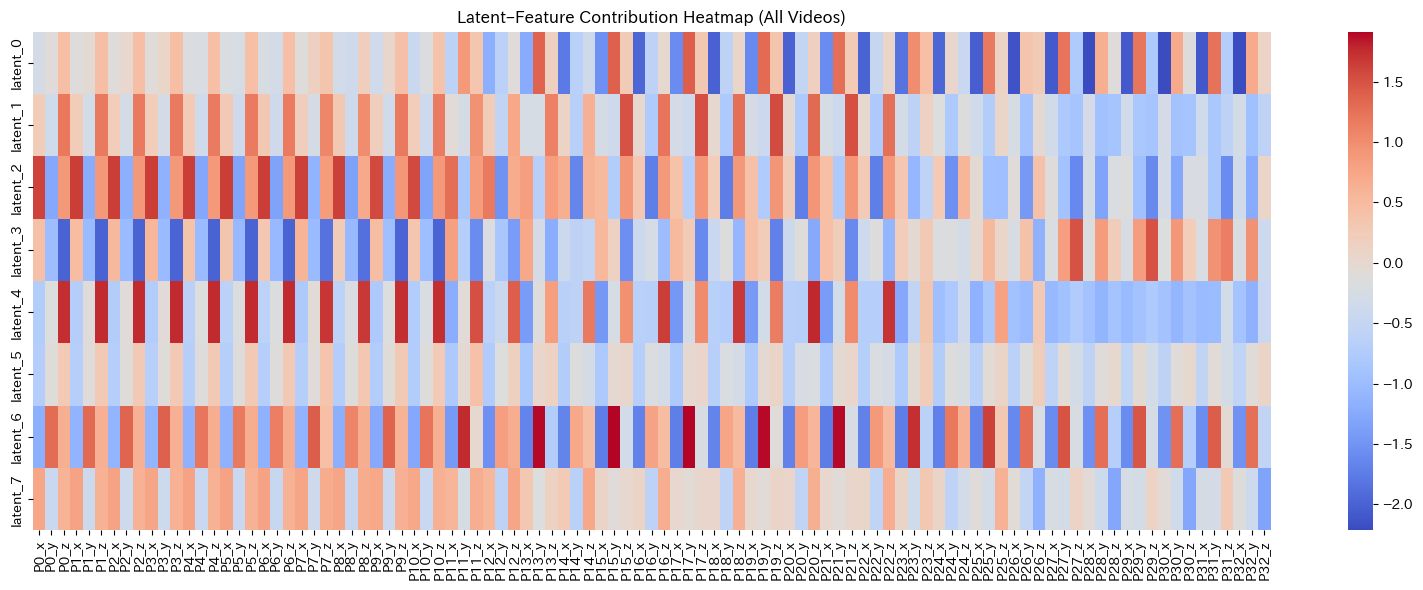

In [117]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from joblib import load
from tqdm import tqdm

# パス設定
input_dir = "../data/normalized_features/default"
model_path = "../models/ae_model.pt"
scaler_path = "../models/scaler.joblib"

# AEモデル定義（または from model import AutoEncoder）
class AutoEncoder(torch.nn.Module):
    def __init__(self, input_dim=66, latent_dim=8):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 48),
            torch.nn.ReLU(),
            torch.nn.Linear(48, 24),
            torch.nn.ReLU(),
            torch.nn.Linear(24, latent_dim)
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, 24),
            torch.nn.ReLU(),
            torch.nn.Linear(24, 48),
            torch.nn.ReLU(),
            torch.nn.Linear(48, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

# モデル・スケーラー読み込み
model = AutoEncoder(input_dim=99, latent_dim=8)
model.load_state_dict(torch.load(model_path, map_location="cpu"))
model.eval()

scaler = load(scaler_path)

# 全CSVを読み込んで特徴量とlatentを集める
X_all = []
Z_all = []

for filename in tqdm(os.listdir(input_dir)):
    if not filename.endswith(".csv"):
        continue
    filepath = os.path.join(input_dir, filename)
    df = pd.read_csv(filepath)
    X = df.drop(columns=["frame"], errors="ignore").values
    X_scaled = scaler.transform(X)

    with torch.no_grad():
        inputs = torch.tensor(X_scaled, dtype=torch.float32)
        Z = model.encoder(inputs).numpy()

    X_all.append(X_scaled)
    Z_all.append(Z)

# 結合
X_all = np.vstack(X_all)
Z_all = np.vstack(Z_all)

# 特徴量・latent名
feature_names = df.columns.drop("frame", errors="ignore")
latent_names = [f"latent_{i}" for i in range(Z_all.shape[1])]

# DataFrame化
df_X = pd.DataFrame(X_all, columns=feature_names)
df_Z = pd.DataFrame(Z_all, columns=latent_names)

# 相関行列（latent × feature）
correlation = df_Z.T.dot(df_X) / len(df_X)  # 共分散ベースの寄与

# 可視化（ヒートマップ）
plt.figure(figsize=(16, 6))
sns.heatmap(correlation, cmap="coolwarm", xticklabels=feature_names, yticklabels=latent_names)
plt.title("Latent–Feature Contribution Heatmap (All Videos)")
plt.tight_layout()
plt.show()


In [118]:
import pandas as pd
import numpy as np

# 相関行列をコピー（DataFrame形式であることを前提）
contrib = correlation.copy()

# 上位特徴量を抽出（絶対値が高いもの）
top_k = 7  # 上位何個を出すか
top_features = {}

for latent in contrib.index:
    abs_corr = contrib.loc[latent].abs()
    top_feats = abs_corr.sort_values(ascending=False).head(top_k).index.tolist()
    top_features[latent] = top_feats

# 出力
for latent, features in top_features.items():
    print(f"\n🔹 {latent} に寄与するTop{top_k}特徴量:")
    for i, feat in enumerate(features, 1):
        val = contrib.loc[latent, feat]
        print(f"  {i}. {feat} (寄与: {val:.3f})")



🔹 latent_0 に寄与するTop7特徴量:
  1. P32_x (寄与: -2.215)
  2. P30_x (寄与: -2.207)
  3. P28_x (寄与: -2.201)
  4. P26_x (寄与: -2.137)
  5. P31_x (寄与: -2.108)
  6. P29_x (寄与: -2.083)
  7. P27_x (寄与: -2.082)

🔹 latent_1 に寄与するTop7特徴量:
  1. P19_z (寄与: 1.546)
  2. P17_z (寄与: 1.523)
  3. P21_z (寄与: 1.520)
  4. P15_z (寄与: 1.500)
  5. P20_z (寄与: 1.334)
  6. P18_z (寄与: 1.279)
  7. P22_z (寄与: 1.266)

🔹 latent_2 に寄与するTop7特徴量:
  1. P18_y (寄与: -1.735)
  2. P16_y (寄与: -1.728)
  3. P20_y (寄与: -1.724)
  4. P22_y (寄与: -1.720)
  5. P14_y (寄与: -1.660)
  6. P4_x (寄与: 1.652)
  7. P5_x (寄与: 1.651)

🔹 latent_3 に寄与するTop7特徴量:
  1. P0_z (寄与: -1.995)
  2. P6_z (寄与: -1.991)
  3. P5_z (寄与: -1.991)
  4. P4_z (寄与: -1.991)
  5. P1_z (寄与: -1.989)
  6. P2_z (寄与: -1.989)
  7. P10_z (寄与: -1.989)

🔹 latent_4 に寄与するTop7特徴量:
  1. P20_z (寄与: 1.785)
  2. P3_z (寄与: 1.761)
  3. P2_z (寄与: 1.761)
  4. P1_z (寄与: 1.761)
  5. P6_z (寄与: 1.758)
  6. P5_z (寄与: 1.757)
  7. P4_z (寄与: 1.757)

🔹 latent_5 に寄与するTop7特徴量:
  1. P13_x (寄与: -0.824)
  2. P15_x

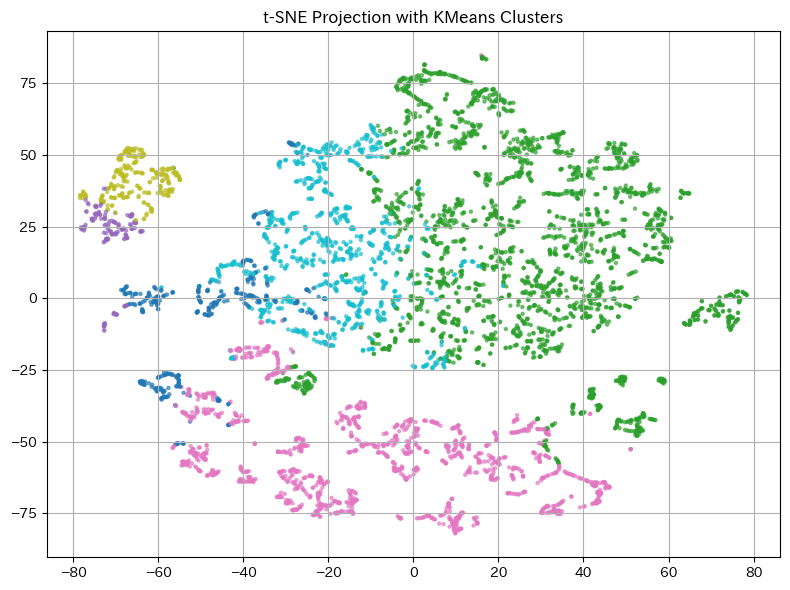

In [119]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# ステップ1：クラスタリング
kmeans = KMeans(n_clusters=6, random_state=42)
cluster_labels = kmeans.fit_predict(Z_all)

# ステップ2：t-SNEで2次元に可視化
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
Z_tsne = tsne.fit_transform(Z_all)

# ステップ3：クラスタラベルで色分け表示
plt.figure(figsize=(8,6))
plt.scatter(Z_tsne[:, 0], Z_tsne[:, 1], c=cluster_labels, s=5, cmap='tab10', alpha=0.6)
plt.title("t-SNE Projection with KMeans Clusters")
plt.grid(True)
plt.tight_layout()
plt.show()


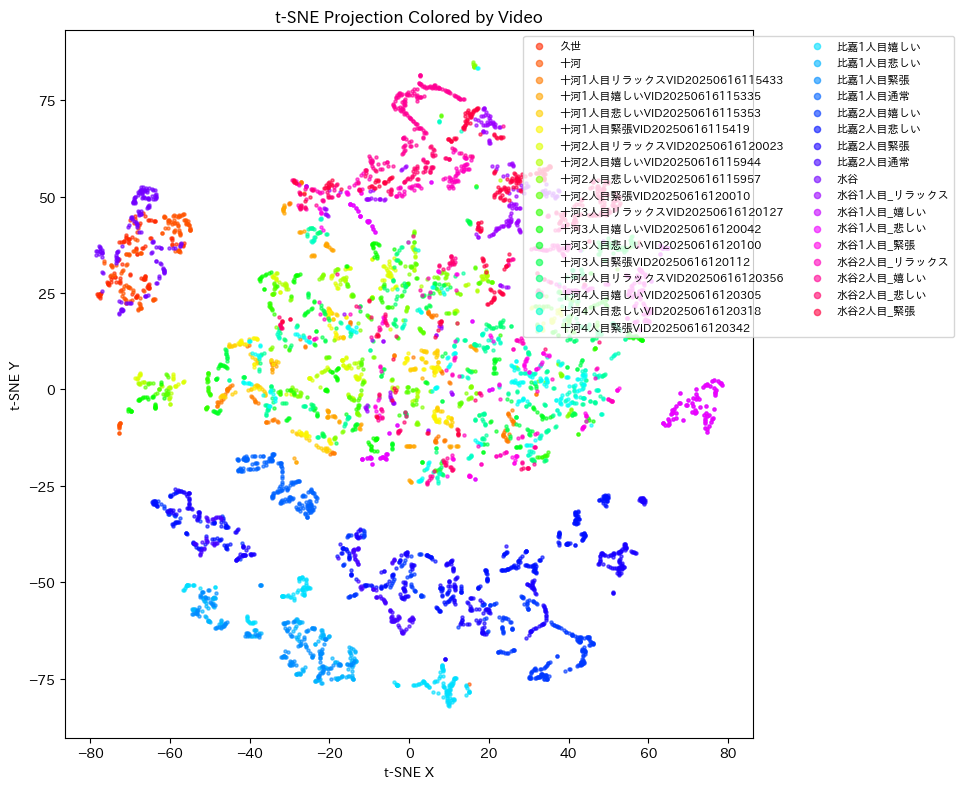

In [120]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import japanize_matplotlib

# t-SNE結果 (Z_tsne: shape [n_frames, 2])
# video_id_list: shape [n_frames] - 各フレームが属する動画ID

df_tsne = pd.DataFrame(Z_tsne, columns=["tsne_x", "tsne_y"])
df_tsne["video_id"] = video_id_list

# パレット作成（動画数に応じた色）
video_ids = df_tsne["video_id"].unique()
palette = sns.color_palette("hsv", len(video_ids))  # HSVなら色がバラけやすい
color_map = dict(zip(video_ids, palette))

# 色を対応させる
df_tsne["color"] = df_tsne["video_id"].map(color_map)

# プロット
plt.figure(figsize=(10, 8))
for video_id, group in df_tsne.groupby("video_id"):
    plt.scatter(group["tsne_x"], group["tsne_y"], s=5, label=video_id, color=color_map[video_id], alpha=0.6)

plt.title("t-SNE Projection Colored by Video")
plt.xlabel("t-SNE X")
plt.ylabel("t-SNE Y")
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.0), fontsize=8, markerscale=2, ncol=2)  # 多い場合調整
plt.tight_layout()
plt.show()


In [121]:
import pandas as pd
import os

# video_id_list: 各フレームがどの動画に属するか（len = フレーム数）
# cluster_labels: 各フレームのクラスタ予測結果（len = フレーム数）

# フレーム単位のDataFrameを作成
df_clustered = pd.DataFrame({
    'video_id': video_id_list,
    'cluster_id': cluster_labels
})

# フレーム番号を動画ごとに連番で付ける（任意）
df_clustered['frame'] = df_clustered.groupby('video_id').cumcount()

# フォルダ作成（なければ）
os.makedirs("../data/cluster", exist_ok=True)

# 🎯 フレーム単位のクラスタ情報を保存
df_clustered.to_csv("../data/cluster/frame_cluster_labels.csv", index=False)

# 🎯 動画単位の代表クラスタ（多数決）を算出して保存
df_majority = df_clustered.groupby('video_id')['cluster_id'] \
    .agg(lambda x: x.value_counts().index[0]) \
    .reset_index()

df_majority.to_csv("../data/cluster/video_cluster_labels.csv", index=False)


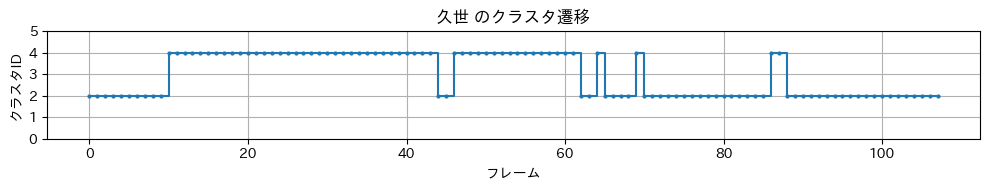

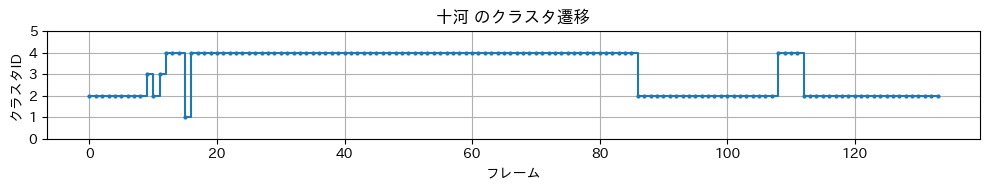

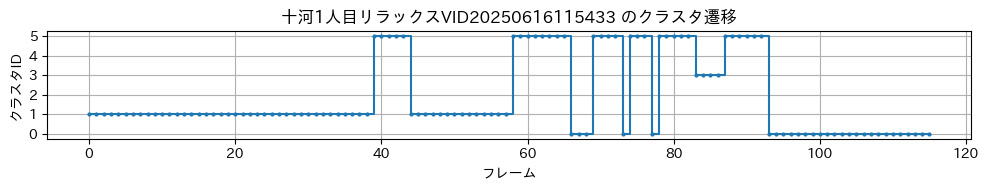

In [122]:
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib  # 日本語対応（必要に応じて）

# CSV読み込み
df = pd.read_csv("../data/cluster/frame_cluster_labels.csv")

# 動画一覧を取得（または一部だけ）
video_ids = df["video_id"].unique()

# グラフ描画（例：最初の3動画だけ）
for video_id in video_ids[:3]:
    df_video = df[df["video_id"] == video_id]
    
    plt.figure(figsize=(10, 2))
    plt.plot(df_video["frame"], df_video["cluster_id"], drawstyle="steps-post", marker='o', markersize=2)
    plt.title(f"{video_id} のクラスタ遷移")
    plt.xlabel("フレーム")
    plt.ylabel("クラスタID")
    plt.yticks(sorted(df["cluster_id"].unique()))
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [123]:
import numpy as np
import pandas as pd
from tqdm import tqdm

# パラメータ
window_size = 25  # 例：20フレーム（約1秒）
stride = 10       # ウィンドウの重なり（5ずつスライド）

# 結果を格納するリスト
window_features = []
window_video_ids = []
window_start_frames = []

# DataFrame化して扱いやすく
df_latent = pd.DataFrame(Z_all, columns=[f'latent_{i}' for i in range(Z_all.shape[1])])
df_latent['video_id'] = video_id_list

# 動画ごとに処理
for video_id in tqdm(df_latent['video_id'].unique()):
    df_vid = df_latent[df_latent['video_id'] == video_id].reset_index(drop=True)
    latent_seq = df_vid.drop(columns='video_id').values
    
    for i in range(0, len(latent_seq) - window_size + 1, stride):
        window = latent_seq[i:i+window_size]
        
        # 特徴抽出：平均・標準偏差・時間勾配（中央差分）
        mean = window.mean(axis=0)
        std = window.std(axis=0)
        grad = np.gradient(window, axis=0).mean(axis=0)
        
        feature = np.concatenate([mean, std, grad])
        window_features.append(feature)
        window_video_ids.append(video_id)
        window_start_frames.append(i)


100%|██████████| 35/35 [00:00<00:00, 423.44it/s]


In [125]:
# 特徴名を生成
latent_dim = Z_all.shape[1]
feature_columns = (
    [f'mean_latent_{i}' for i in range(latent_dim)] +
    [f'std_latent_{i}' for i in range(latent_dim)] +
    [f'grad_latent_{i}' for i in range(latent_dim)]
)

df_window_features = pd.DataFrame(window_features, columns=feature_columns)
df_window_features['video_id'] = window_video_ids
df_window_features['start_frame'] = window_start_frames

# 保存（必要なら）
df_window_features.to_csv("../data/cluster/window_features.csv", index=False)


In [126]:
df_f = pd.read_csv("../data/cluster/window_features.csv")
df_f.head(10)

,mean_latent_0,mean_latent_1,mean_latent_2,mean_latent_3,mean_latent_4,mean_latent_5,mean_latent_6,mean_latent_7,std_latent_0,std_latent_1,...,grad_latent_0,grad_latent_1,grad_latent_2,grad_latent_3,grad_latent_4,grad_latent_5,grad_latent_6,grad_latent_7,video_id,start_frame
0,-1.281143,-2.253949,1.312583,9.183126,-12.930495,2.378024,1.098871,-0.233070,2.663443,1.601511,...,0.325062,-0.165689,0.003368,-0.513155,0.764401,0.007796,-0.144823,0.055672,久世,0
1,0.552014,-2.586228,0.863695,6.550783,-8.185853,1.913399,0.604799,0.503818,0.722277,0.777677,...,0.054897,-0.123212,-0.072581,-0.044810,0.203654,-0.014976,-0.047929,0.028626,久世,10
2,0.251987,-3.001877,-0.231212,7.467322,-8.268647,1.673911,0.299079,0.997864,0.539797,0.529245,...,-0.064167,-0.023349,0.087453,0.096227,-0.253725,0.018506,0.116374,0.068177,久世,20
3,0.457376,-3.674056,0.083743,7.953734,-9.312503,1.725554,0.456288,0.870049,0.883112,1.031749,...,0.030389,-0.141713,0.048613,0.162723,-0.282050,0.029810,-0.061118,-0.174458,久世,30
4,0.897107,-4.798498,0.603182,8.664277,-10.317688,1.838001,0.272151,0.153912,0.940872,1.014913,...,-0.006948,-0.137351,0.094083,0.056464,-0.083099,0.014285,0.092746,0.088376,久世,40
5,0.569258,-5.672961,-1.261574,10.030560,-10.479748,1.752318,-0.022418,1.702458,1.188777,0.701879,...,-0.061735,-0.038253,-0.254841,0.302475,-0.149882,-0.032248,-0.105574,0.033399,久世,50
6,0.275284,-6.208020,-2.157008,11.594170,-13.127769,2.171638,0.015460,2.574545,1.050299,0.899131,...,0.048413,-0.081275,-0.092139,0.049498,-0.318136,0.112312,-0.020278,0.126816,久世,60
7,1.719157,-6.799044,-1.726023,12.179015,-14.662811,2.306192,-0.701667,0.570904,1.555047,1.042763,...,0.078489,-0.058520,0.102419,0.060932,-0.055261,-0.012720,0.003837,-0.127902,久世,70
8,2.079582,-8.112764,0.111558,12.270229,-13.267981,1.860194,0.950612,1.359236,1.187387,1.200507,...,0.032858,-0.064151,0.041158,-0.021477,0.418922,-0.144151,0.140980,0.164633,久世,80
9,-1.781145,-2.802759,1.418471,5.673852,-15.442408,-1.980582,-0.985400,3.911191,2.910717,3.039103,...,0.105569,0.236716,-0.045799,-0.140237,1.139164,0.356871,-0.003227,-0.314241,十河,0


In [127]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# 読み込み
df = pd.read_csv("../data/cluster/window_features.csv")

# 数値特徴量だけを抽出（mean, std, grad 系）
feature_cols = [col for col in df.columns if col.startswith(('mean_', 'std_', 'grad_'))]
X = df[feature_cols].values

# 標準化（クラスタリング前に必須）
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [128]:
from sklearn.cluster import KMeans

k = 4 # 仮のクラスタ数（あとで調整可能）
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

df["cluster_id"] = cluster_labels
df.to_csv("../data/cluster/window_features_clustered.csv", index=False)


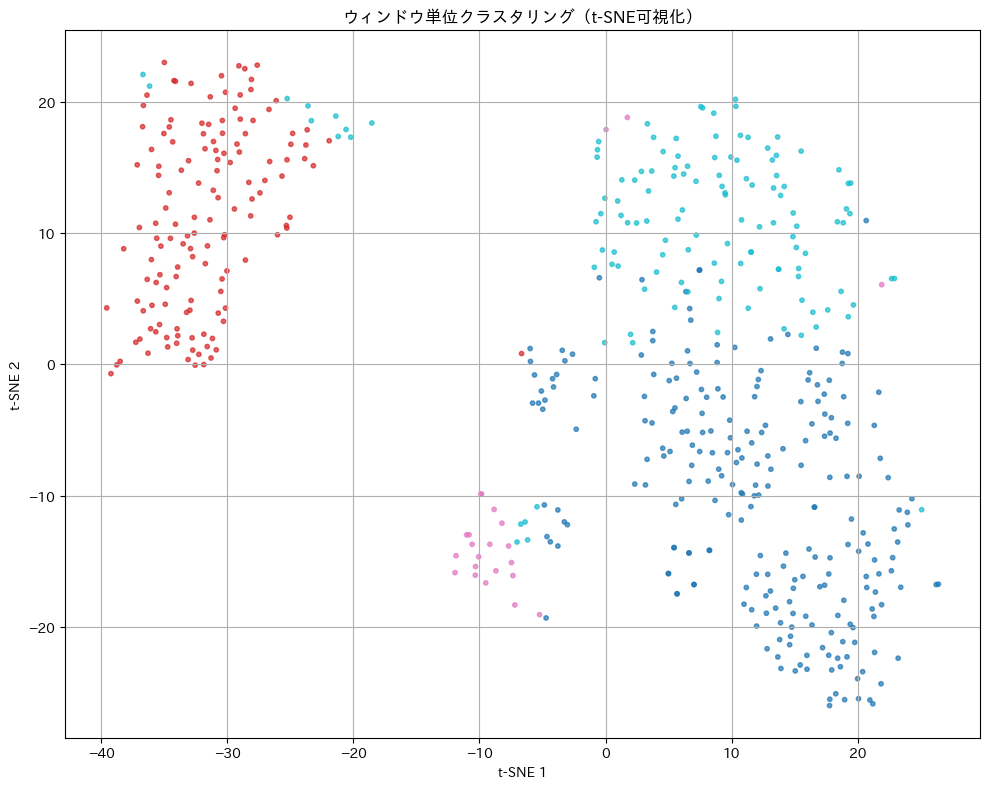

In [129]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import japanize_matplotlib  # 日本語表示（必要なら）

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# 可視化
plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_labels, cmap='tab10', s=10, alpha=0.7)
plt.title("ウィンドウ単位クラスタリング（t-SNE可視化）")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.tight_layout()
plt.show()


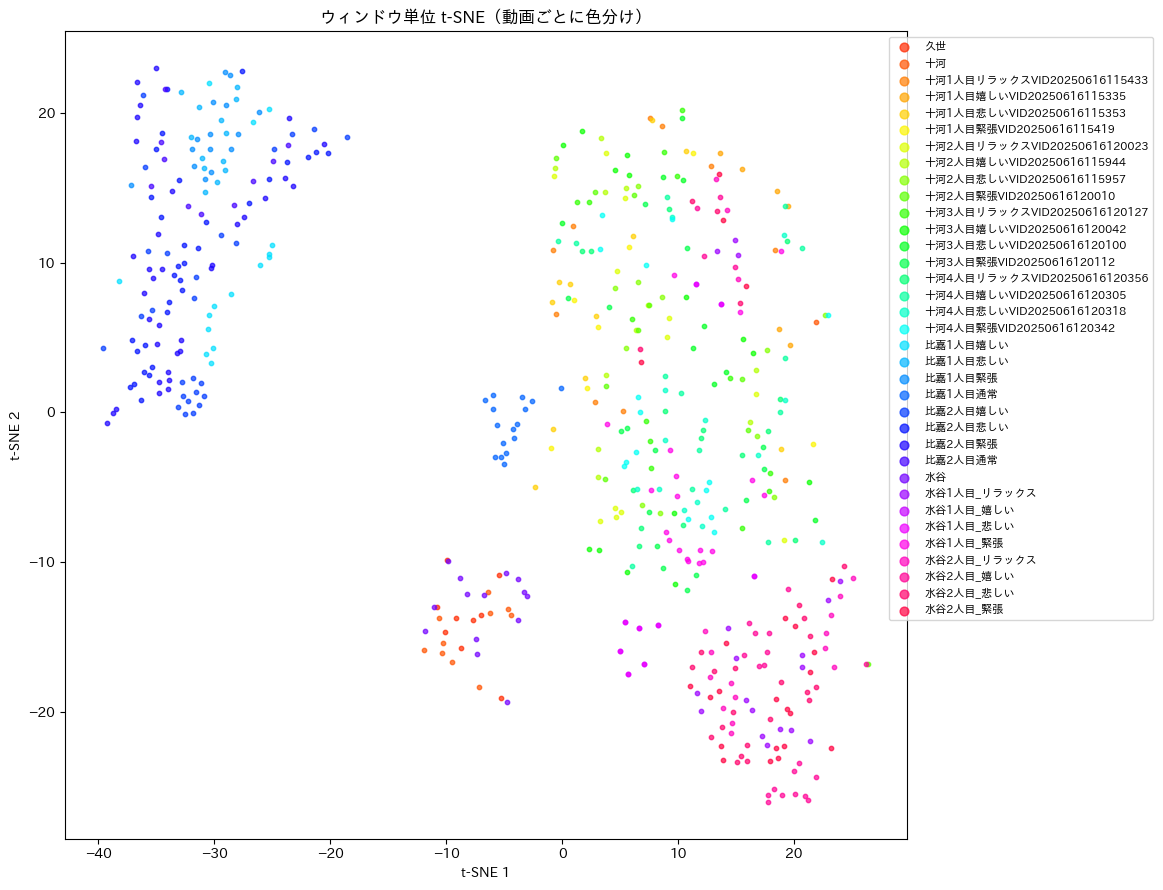

In [130]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import japanize_matplotlib  # 日本語表示のため

# データ読み込み（再利用もOK）
df = pd.read_csv("../data/cluster/window_features_clustered.csv")

# t-SNE結果が X_tsne にある前提（shape: [N, 2]）
df_tsne = pd.DataFrame(X_tsne, columns=["tsne_x", "tsne_y"])
df_tsne["video_id"] = df["video_id"]

# カラーパレットを作成
video_ids = df_tsne["video_id"].unique()
palette = sns.color_palette("hsv", len(video_ids))
color_map = dict(zip(video_ids, palette))
df_tsne["color"] = df_tsne["video_id"].map(color_map)

# プロット
plt.figure(figsize=(12, 9))
for video_id, group in df_tsne.groupby("video_id"):
    plt.scatter(group["tsne_x"], group["tsne_y"], s=10, label=video_id, color=color_map[video_id], alpha=0.7)

plt.title("ウィンドウ単位 t-SNE（動画ごとに色分け）")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1), fontsize=8, markerscale=2)
plt.tight_layout()
plt.show()


In [131]:
import pandas as pd

# クロス集計（動画 × クラスタの出現数）
df_counts = df.groupby(["video_id", "cluster_id"]).size().unstack(fill_value=0)

# 構成比（割合）に変換
df_ratios = df_counts.div(df_counts.sum(axis=1), axis=0)


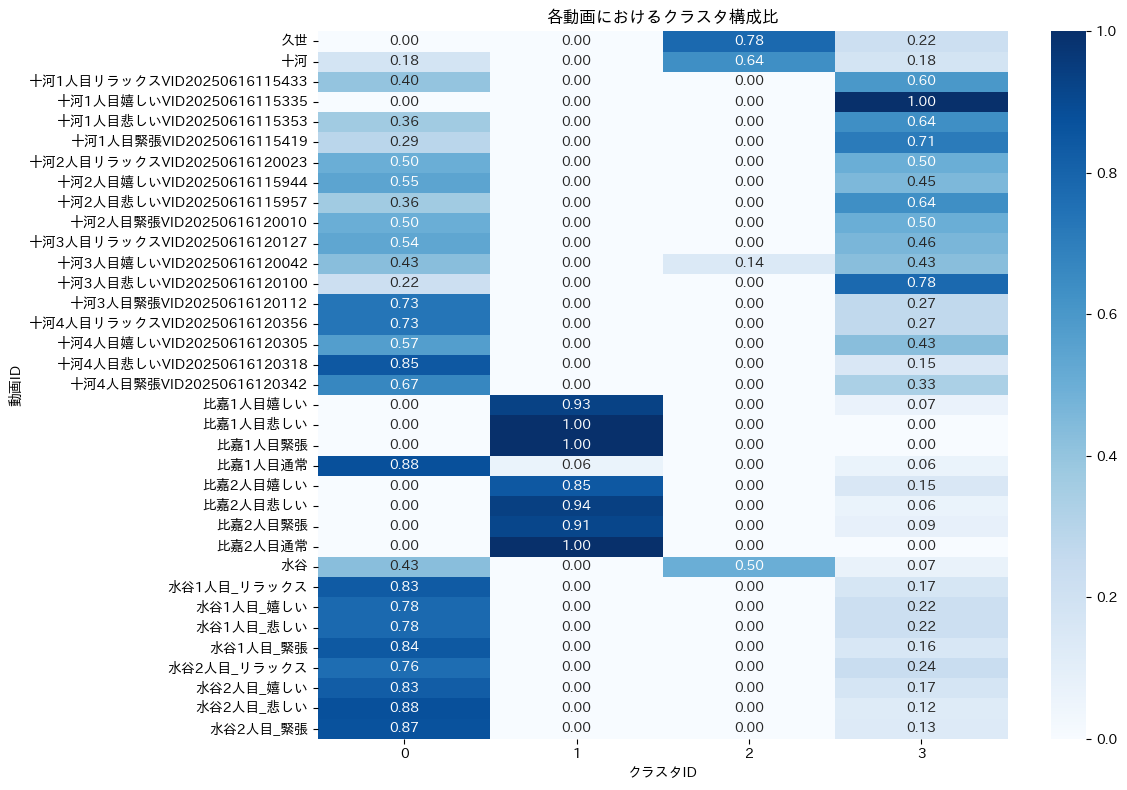

In [132]:
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib  # 日本語表示

plt.figure(figsize=(12, 8))
sns.heatmap(df_ratios, annot=True, cmap="Blues", fmt=".2f", cbar=True)
plt.title("各動画におけるクラスタ構成比")
plt.xlabel("クラスタID")
plt.ylabel("動画ID")
plt.tight_layout()
plt.show()


In [133]:
print("元のフレーム数:", len(Z_all))
print("抽出されたウィンドウ数:", len(window_features))
print("ユニーク動画数:", len(set(window_video_ids)))


元のフレーム数: 5932
抽出されたウィンドウ数: 524
ユニーク動画数: 35
